### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using Plots, LaTeXStrings, Random, Dierckx, DelimitedFiles, ProgressMeter
include("network_STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("network_STG_models.jl") # Loading of STG model
include("network_STG_utils.jl") # Loading of some utils functions
include("network_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("network_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("network_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 100000
const dt = 0.0005
const tsim = 0 : dt : Tfinal
const dtplot = 0.2
const tt = 0 : dtplot : Tfinal
const dtratio = Int(dtplot/dt)
const Tdt = Int(Tfinal/dt)
const tt_index = 1 : dtratio : Tdt+1

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const Vsyn = -75. # Reversal potential of synaptic channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 5

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
default(fmt = :png);

# **Test of simple modulated network with constant DICs**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
tmKCavec = [2.; 2.; 2.; 20.; 20.]
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth, tmKCavec);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
Iappvec = 0. * ones(5)
gNavec = g_all_init[:, 1]
gCaTvec = g_all_init[:, 2]
gCaSvec = g_all_init[:, 3]
gAvec = g_all_init[:, 4]
gKCavec = g_all_init[:, 5]
gKdvec = g_all_init[:, 6]
gHvec = g_all_init[:, 7]
gleakvec = g_all_init[:, 8]

α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim_nocrash(t) = -8.
gsth_sim_crash(t) = 0.
gsth_sim_spike(t) = 5.
gsthvec_nocrash = [gsth_sim_nocrash, gsth_sim_nocrash, gsth_sim_nocrash, 
                    gsth_sim_nocrash, gsth_sim_nocrash]
gsthvec_crash = [gsth_sim_crash, gsth_sim_crash, gsth_sim_crash, 
                  gsth_sim_crash, gsth_sim_crash]
gsthvec_semicrash = [gsth_sim_nocrash, gsth_sim_nocrash, gsth_sim_nocrash, 
                      gsth_sim_crash, gsth_sim_crash]
gsthvec_spike = [gsth_sim_spike, gsth_sim_spike, gsth_sim_spike,
                  gsth_sim_spike, gsth_sim_spike]
guth_sim(t) = 4.
guthvec = [guth_sim, guth_sim, guth_sim, guth_sim, guth_sim]
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7
Vthvec = ICs_th_init[:, 1]

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600. * ones(5) # Integral action time constants
Ca_tgt = 125. # Calcium target

gsyn21 = 0.2*4
gsyn12 = 0.2*4
gsyn13 = 0.2*4
gsyn53 = 0.2*4
gsyn54 = 0.2*4
gsyn45 = 0.2*4
gEl23 = 0.05
gEl43 = 0.05

@time (Vnoconnect, Canoconnect) = simulateSTG_network(
                                       Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                       gHvec, gleakvec, tau_g, tau_Na, Ca_tgt, 
                                       0., 0., 0., 0., 0., 0., 0., 0., tmKCavec, 
                                       α, β, Kp, Ki, Kt, gsthvec_nocrash, guthvec, Vthvec, 
                                       u_maxCaS, u_maxA)

@time (Vconnect_HC0, Caconnect_HC0) = simulateSTG_network(
                                         Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                         gHvec, gleakvec, tau_g, tau_Na, Ca_tgt,
                                         gsyn21, gsyn12, 0., 0., gsyn45, gsyn54, 
                                         0., 0., tmKCavec, α, β, Kp, Ki, Kt, gsthvec_nocrash, 
                                         guthvec, Vthvec, u_maxCaS, u_maxA)

@time (Vconnect, Caconnect) = simulateSTG_network(
                                     Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                     gHvec, gleakvec, tau_g, tau_Na, Ca_tgt, 
                                     gsyn21, gsyn12, gsyn13, gsyn53, gsyn45, gsyn54, 
                                     gEl23, gEl43, tmKCavec, α, β, Kp, Ki, Kt, gsthvec_nocrash, 
                                     guthvec, Vthvec, u_maxCaS, u_maxA)

@time (Vconnect_crash, Caconnect_crash) = simulateSTG_network(
                                           Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                           gHvec, gleakvec, tau_g, tau_Na, Ca_tgt, 
                                           gsyn21, gsyn12, gsyn13, gsyn53, gsyn45, gsyn54, 
                                           gEl23, gEl43, tmKCavec, α, β, Kp, Ki, Kt, gsthvec_crash, 
                                           guthvec, Vthvec, u_maxCaS, u_maxA)

@time (Vconnect_semicrash, Caconnect_semicrash) = simulateSTG_network(
                                               Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
                                               gHvec, gleakvec, tau_g, tau_Na, Ca_tgt, 
                                               gsyn21, gsyn12, gsyn13, gsyn53, gsyn45, 
                                               gsyn54, gEl23, gEl43, tmKCavec, α, β, Kp, Ki, Kt, 
                                               gsthvec_semicrash, guthvec, Vthvec, u_maxCaS, u_maxA);

Computing ... 100%|██████████████████████████████████████| Time: 0:15:21m
Computing ...   0%|█                                     |  ETA: 0:16:19

926.079738 seconds (3.41 G allocations: 289.720 GiB, 2.50% gc time, 0.18% compilation time: 1% of which was recompilation)


Computing ... 100%|██████████████████████████████████████| Time: 0:15:20


924.629033 seconds (3.40 G allocations: 289.308 GiB, 2.62% gc time)


Computing ... 100%|██████████████████████████████████████| Time: 0:15:29


933.441249 seconds (3.40 G allocations: 289.308 GiB, 2.61% gc time)


Computing ... 100%|██████████████████████████████████████| Time: 0:15:26
Computing ...   0%|█                                     |  ETA: 0:14:04

930.722917 seconds (3.40 G allocations: 289.377 GiB, 2.43% gc time, 0.08% compilation time)


Computing ... 100%|██████████████████████████████████████| Time: 0:15:20


924.928087 seconds (3.40 G allocations: 289.372 GiB, 2.51% gc time, 0.05% compilation time)


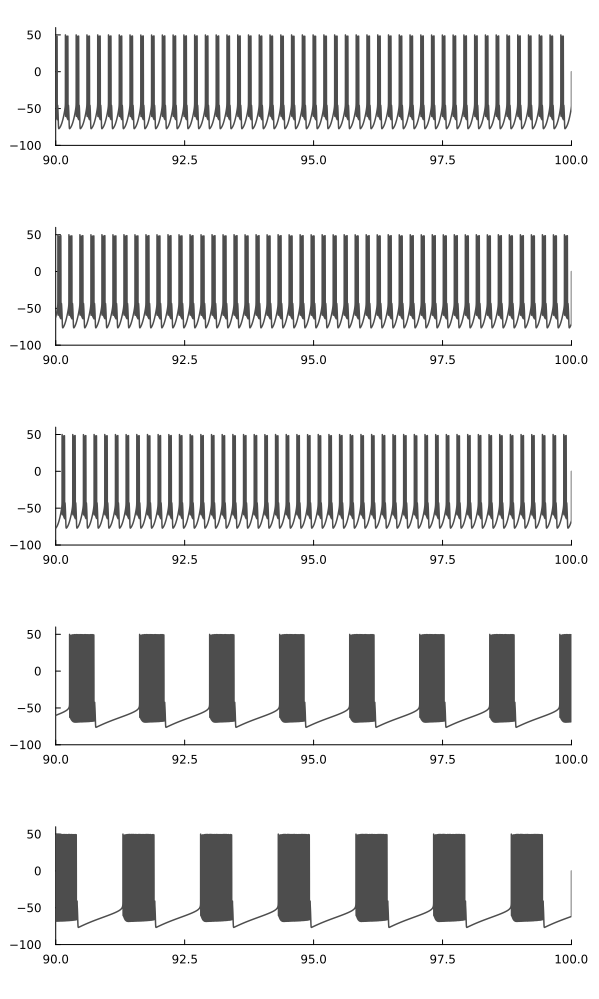

In [7]:
p1 = plot(tt/1e3, Vnoconnect[:, 1], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vnoconnect[:, 2], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vnoconnect[:, 3], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vnoconnect[:, 4], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vnoconnect[:, 5], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

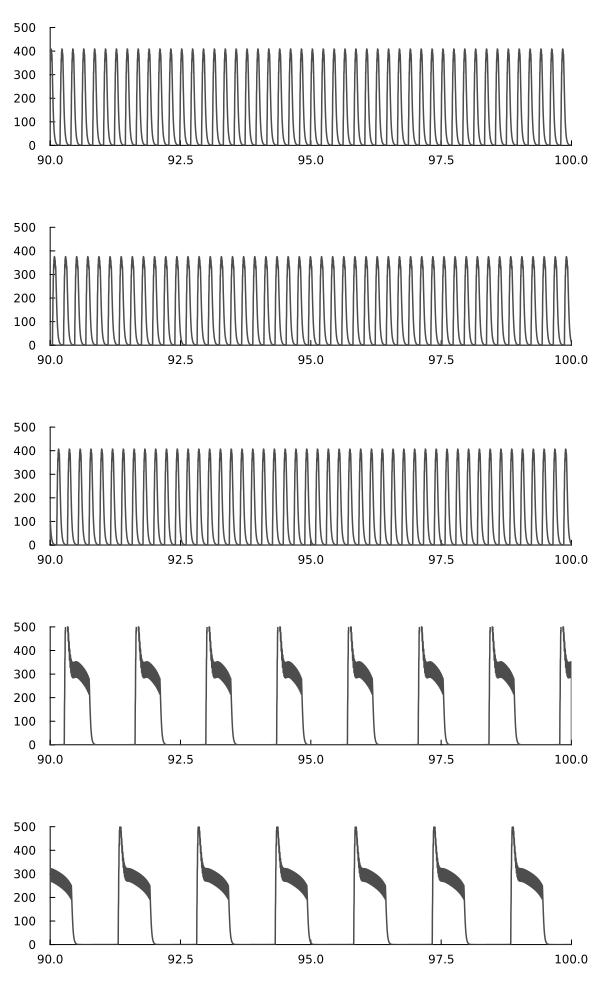

In [17]:
p1 = plot(tt/1e3, Canoconnect[:, 1], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Canoconnect[:, 2], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Canoconnect[:, 3], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Canoconnect[:, 4], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Canoconnect[:, 5], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

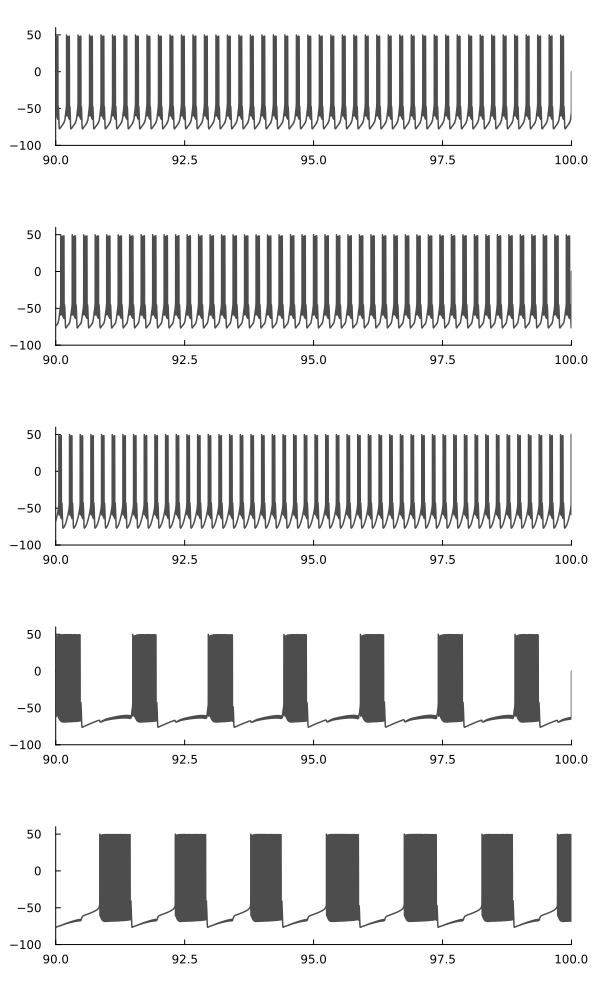

In [27]:
p1 = plot(tt/1e3, Vconnect_HC0[:, 1], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect_HC0[:, 2], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect_HC0[:, 3], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect_HC0[:, 4], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect_HC0[:, 5], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

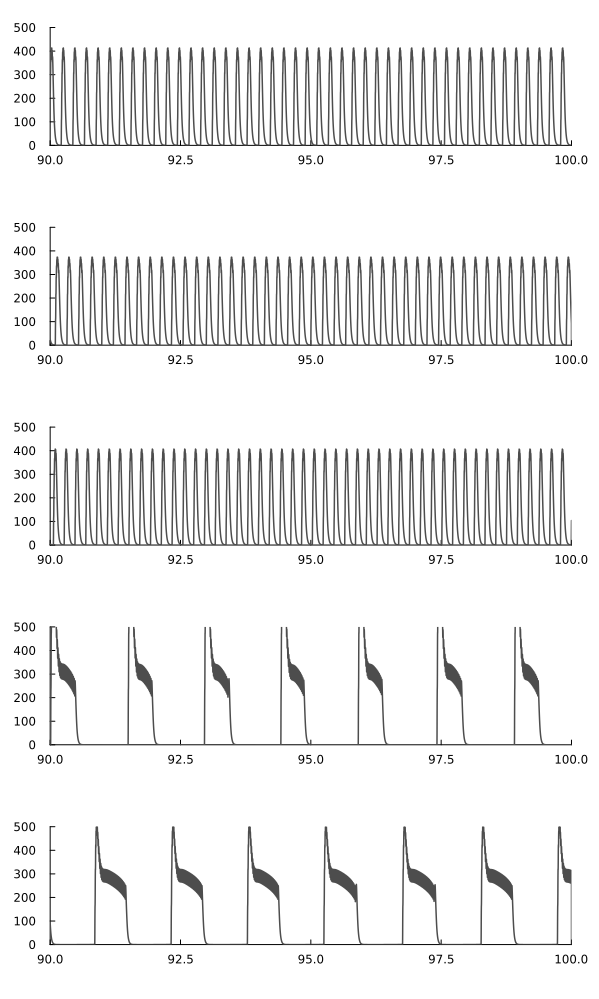

In [30]:
p1 = plot(tt/1e3, Caconnect_HC0[:, 1], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Caconnect_HC0[:, 2], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Caconnect_HC0[:, 3], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Caconnect_HC0[:, 4], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Caconnect_HC0[:, 5], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

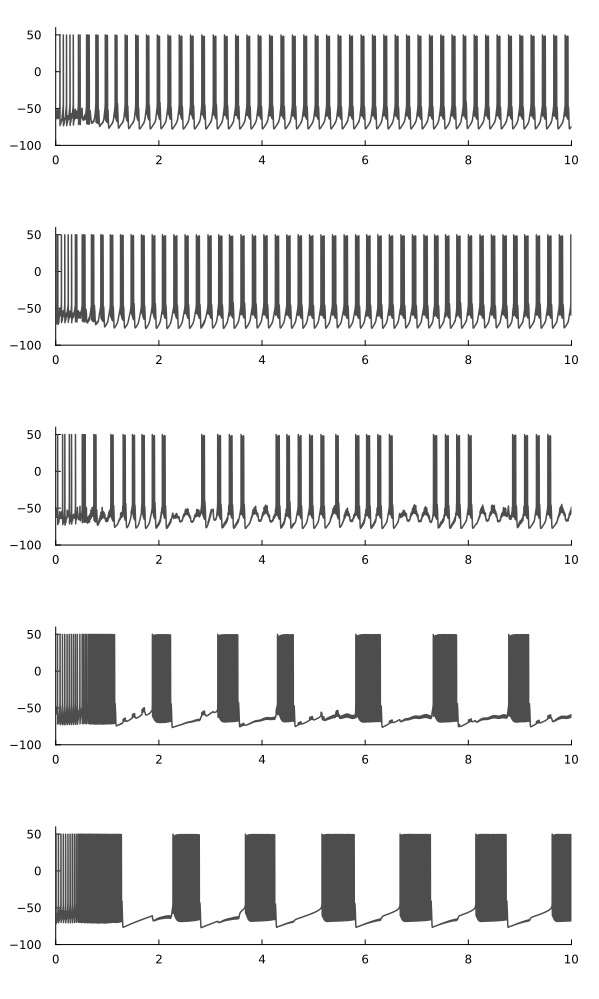

In [36]:
p1 = plot(tt/1e3, Vconnect[:, 1], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect[:, 2], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect[:, 3], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect[:, 4], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect[:, 5], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

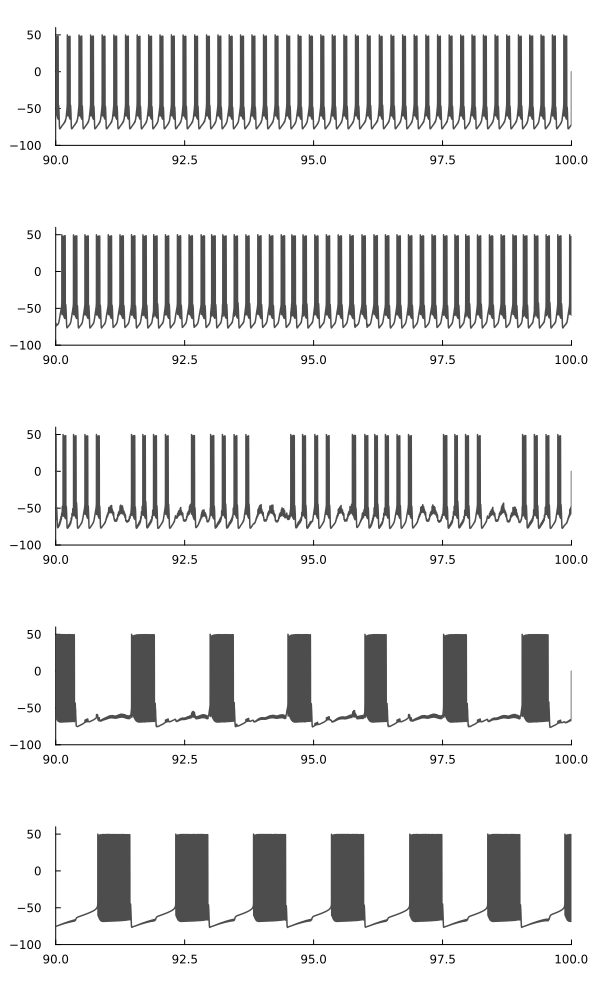

In [37]:
p1 = plot(tt/1e3, Vconnect[:, 1], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect[:, 2], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect[:, 3], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect[:, 4], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect[:, 5], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

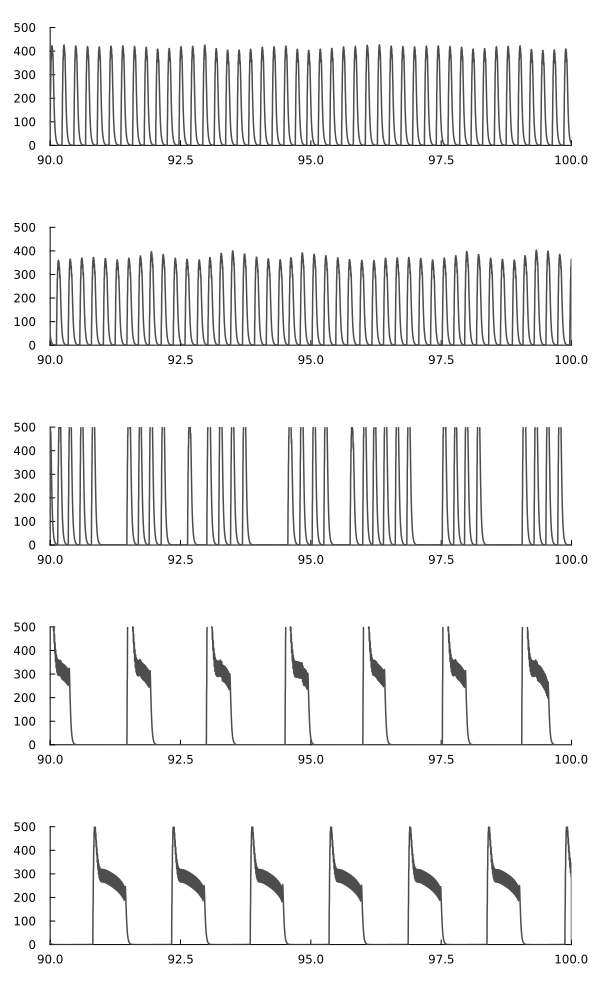

In [47]:
p1 = plot(tt/1e3, Caconnect[:, 1], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Caconnect[:, 2], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Caconnect[:, 3], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Caconnect[:, 4], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Caconnect[:, 5], xlims=(90, 100), ylims=(0, 500), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

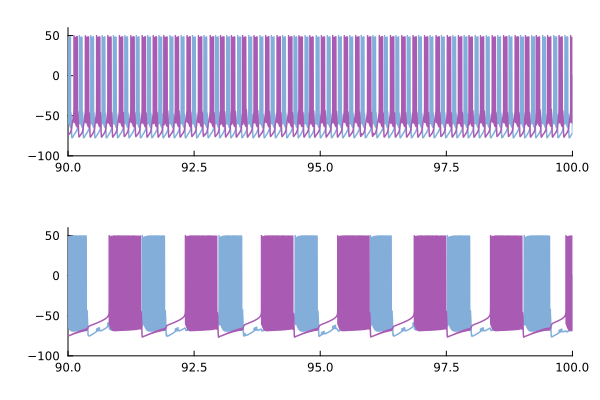

In [39]:
p1 = plot(tt/1e3, Vconnect[:, 1], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myBlue)
plot!(tt/1e3, Vconnect[:, 2], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myPurple)
p2 = plot(tt/1e3, Vconnect[:, 4], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myBlue)
plot!(tt/1e3, Vconnect[:, 5], xlims=(90, 100), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=myPurple)
CC1 = plot(p1, p2, layout=(2, 1), size=(600, 400))

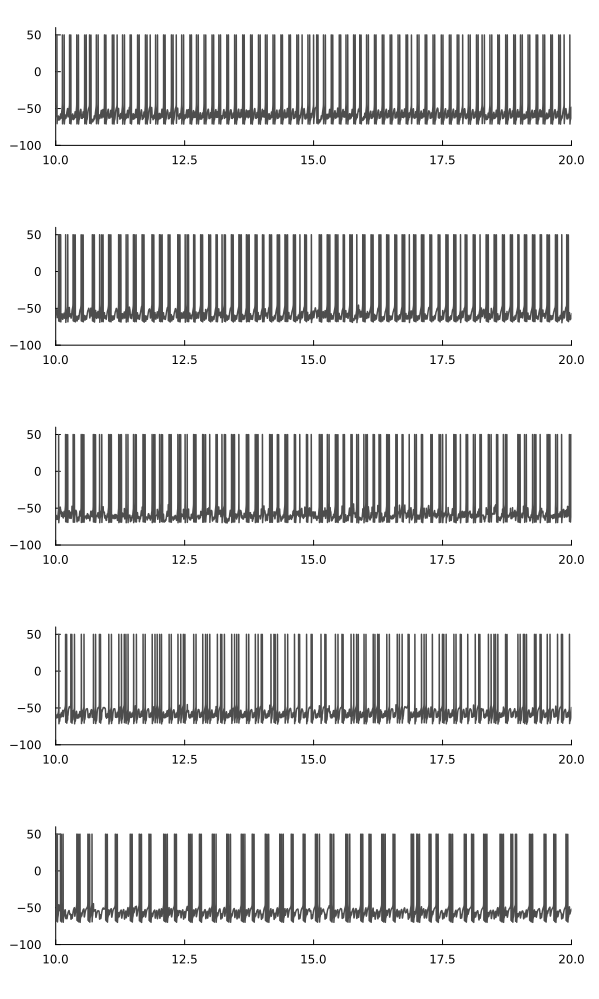

In [40]:
p1 = plot(tt/1e3, Vconnect_crash[:, 1], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect_crash[:, 2], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect_crash[:, 3], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect_crash[:, 4], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect_crash[:, 5], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

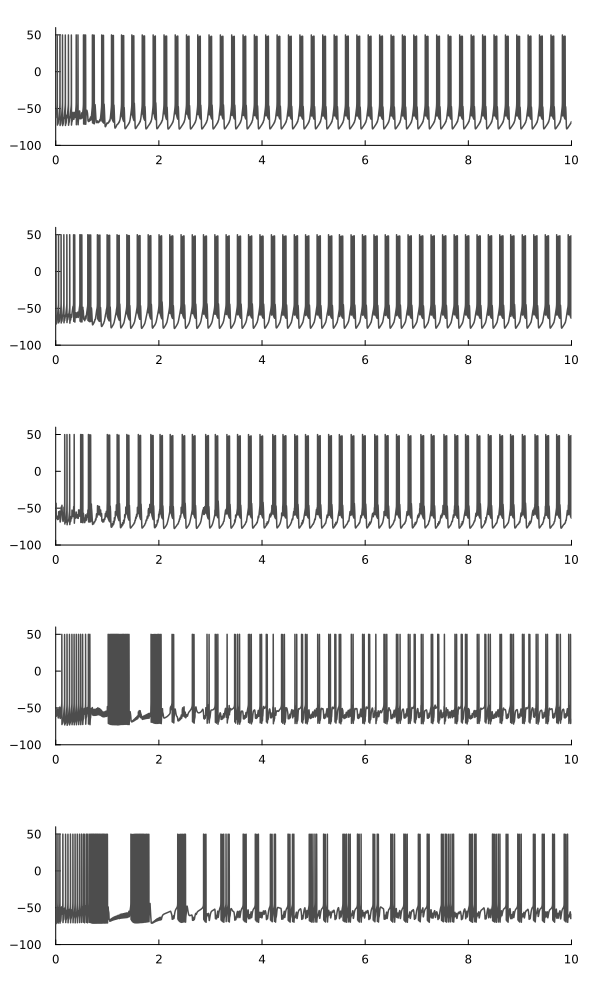

In [48]:
p1 = plot(tt/1e3, Vconnect_semicrash[:, 1], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect_semicrash[:, 2], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect_semicrash[:, 3], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect_semicrash[:, 4], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect_semicrash[:, 5], xlims=(0, 10), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))

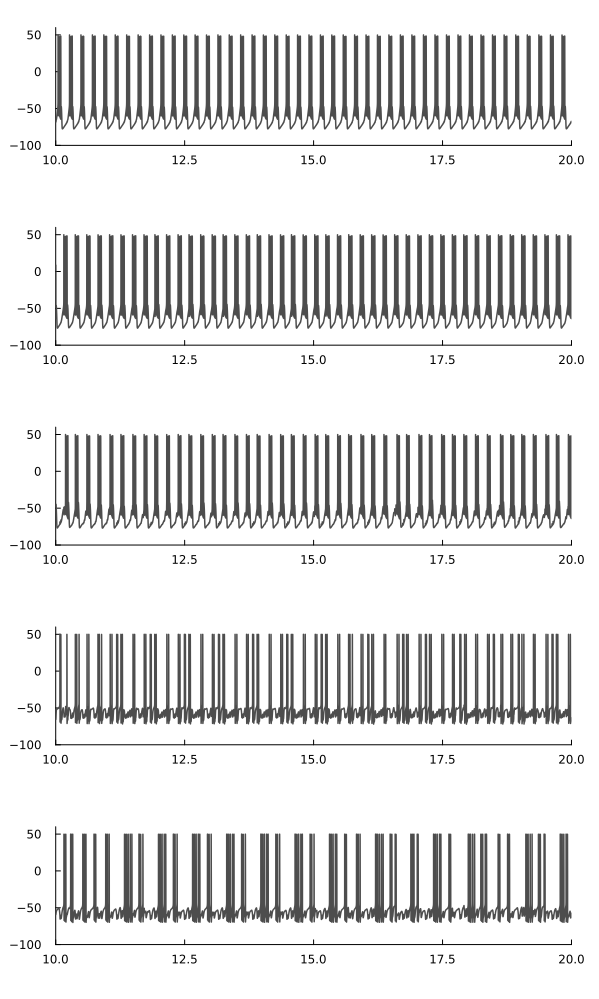

In [49]:
p1 = plot(tt/1e3, Vconnect_semicrash[:, 1], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p2 = plot(tt/1e3, Vconnect_semicrash[:, 2], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p3 = plot(tt/1e3, Vconnect_semicrash[:, 3], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p4 = plot(tt/1e3, Vconnect_semicrash[:, 4], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
p5 = plot(tt/1e3, Vconnect_semicrash[:, 5], xlims=(10, 20), ylims=(-100,60), linewidth=1.5, 
          legend=false, size=(600, 200), color=:gray30)
CC1 = plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(600, 1000))